In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
# from lib_for_growth_model import *
from lib_for_analysis import *
from decimal import Decimal
import numpy as np
from scipy.stats import gaussian_kde
from pandas_helper import *
import seaborn as sns
from pandas import read_csv

In [3]:
# from pandas_datareader import wb

In [4]:
nameofthisround = 'dec2015'
model = os.getcwd()
bau_folder   = "{}/baselines_{}/".format(model,nameofthisround)
cc_folder    = "{}/with_cc_{}/".format(model,nameofthisround)
list_bau = os.listdir(bau_folder)
list_cc  = os.listdir(cc_folder)

In [5]:
def correct_countrycode(countrycode):
    '''
    Corrects countrycodes in the database that don't correspond to official 3 letters codes.
    '''
    if countrycode=='TMP':
        countrycode='TLS'
    if countrycode=='ZAR':
        countrycode='COD'
    if countrycode=='ROM':
        countrycode='ROU'
    return countrycode

def read_results():
    codes = read_csv('wbccodes2014.csv')
    ini_data = pd.read_csv("ini_data_info_may14-bramka.csv")
    codes['country'] = codes.country.apply(correct_countrycode)
    
    bau = pd.DataFrame()
    cc  = pd.DataFrame()

    for file in list_bau:
        #print(file)
        try:
            bau = bau.append(pd.read_csv(bau_folder+file).drop('Unnamed: 0',axis=1))
        except:
            try:
                bau = bau.append(pd.read_csv(bau_folder+file))
            except:
                pass

    for file in list_cc:
        try:
            cc = cc.append(pd.read_csv(cc_folder+file).drop('Unnamed: 0',axis=1))
        except:
            try:
                cc = cc.append(pd.read_csv(cc_folder+file))
            except:
                pass
            
    cc['issp5'] = cc.ssp=='ssp5'
    bau['issp5'] = bau.ssp=='ssp5'
    
    bau['countryname'] = bau.country.replace(codes.set_index('country').country_name)
    cc['countryname'] = cc.country.replace(codes.set_index('country').country_name)
    #ini_data['countryname'] = ini_data.country.replace(codes.set_index('country').country_name)
    ini_data['countryname'] = ini_data['country']
    
    return ini_data, bau, cc

def calculate_shares_40pct_avg(bau, ini_data):
    incbott40_ini = dict(zip(ini_data['country'], ini_data['incbott40']))
    avincome_ini = dict(zip(ini_data['country'], ini_data['avincome']))
    
    bau['shprosp'] = bau.incbott40/bau.avincome
    bau['incbott40_gr'] = bau.apply(lambda x: (x['incbott40']/incbott40_ini[x['country']])**(1/(2030-2007)), axis=1)
    bau['avincome_gr'] = bau.apply(lambda x: (x['avincome']/avincome_ini[x['country']])**(1/(2030-2007)), axis=1)
    bau['shprosp_pc'] = bau['incbott40_gr'] - bau['avincome_gr']
    
    return bau

In [6]:
ini_data, bau, cc = read_results()
bau = calculate_shares_40pct_avg(bau, ini_data)
print(len(ini_data), len(bau), len(cc))

91 54600 15600


In [7]:
bau['below125_pc'] = bau['below125'] / bau['tot_pop']
cc['below125_pc'] = cc['below125'] / cc['tot_pop']

In [8]:
bau.columns

Index(['GDP', 'avincome', 'avincomeag', 'avincomenonag', 'b', 'below10',
       'below125', 'below2', 'below4', 'below6', 'below8', 'childrenag',
       'childrenonag', 'country', 'gap10', 'gap125', 'gap2', 'gap4', 'gap6',
       'gap8', 'gini', 'grag', 'grmanu', 'grserv', 'inc2040', 'incbott10',
       'incbott20', 'incbott20ag', 'incbott20nonag', 'incbott40',
       'incsharebott20ag', 'incsharebott20nonag', 'p', 'peopleag',
       'peoplenonag', 'poorag', 'poornonag', 'prod_gr_ag', 'prod_gr_manu',
       'prod_gr_serv', 'quintile1', 'quintile2', 'quintilecum1',
       'quintilecum2', 'quintilepc1', 'quintilepc2', 'scenar', 'shareag',
       'shareemp', 'sharemanu', 'skillpag', 'skillpmanu', 'skillpserv', 'ssp',
       'tot_pop', 'year', 'issp5', 'countryname', 'shprosp', 'incbott40_gr',
       'avincome_gr', 'shprosp_pc', 'below125_pc'],
      dtype='object')

In [9]:
outcomes_col = ['GDP', 'avincome','incbott20', 'inc2040', 'incbott40', 'below125', 'below125_pc','shprosp', 'shprosp_pc', 'gini']
experiments_col = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag','grmanu',\
                   'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b']

## Identification of main drivers
Based on: https://github.com/julierozz/scenarios-paper/blob/master/analyze%20Ethiopia-june%202018.ipynb

### ANOVA - Worldwide

In [10]:
def calculate_anova_all_outcomes(forprim, outcomes_col, experiments_col):
    all_anova = pd.DataFrame()
    
    for outcome in outcomes_col:
        drivers,sumvar,table = drivers_from_anova(outcome,forprim,experiments_col, return_table=True)
        table = table[['sum_sq_pc']]
        table['outcome_var'] = outcome
        all_anova = all_anova.append(table)
        
    all_anova.reset_index(inplace=True)
    all_anova.columns = ['experiments_var', 'sum_sq_pc', 'outcome_var']
    all_anova = all_anova.loc[all_anova['experiments_var']!='Residual']
        
    return pd.pivot_table(all_anova, columns=['outcome_var'], values='sum_sq_pc', index=['experiments_var'])

In [11]:
drivers,sumvar,table = drivers_from_anova("incbott20",bau,experiments_col, return_table=True)
drivers,sumvar

(['shareag', 'grserv', 'b'], 0.08558648223060664)

In [12]:
all_anova = calculate_anova_all_outcomes(bau, outcomes_col, experiments_col)

anova for all outcome variables at once

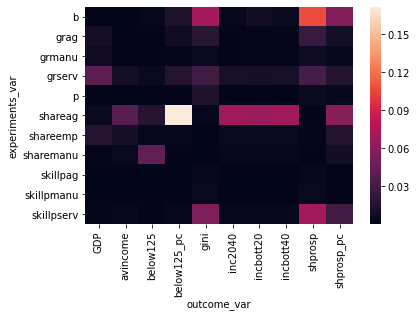

In [13]:
sns.heatmap(all_anova)

anova for individual outcome variables

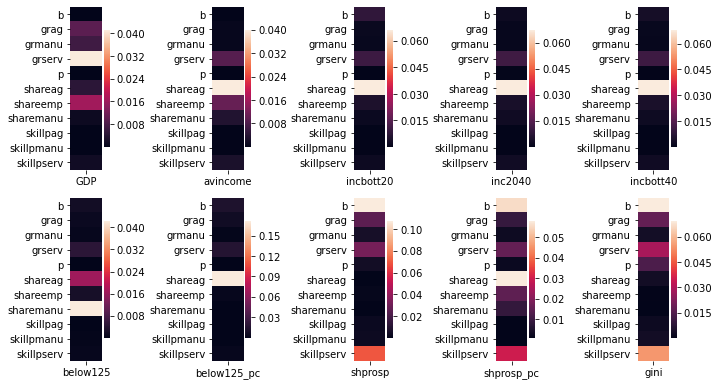

In [14]:
#
cols = 5
rows = int(np.ceil(len(outcomes_col)/cols))
fig, axes = plt.subplots(rows,cols, figsize=(10,6))
row = 0
col = 0
for outcome in outcomes_col:
    sns.heatmap(all_anova[[outcome]], ax=axes[row,col])
    axes[row,col].set_xlabel('')
    axes[row,col].set_ylabel('')
    if col < cols-1:
        col += 1
    else:
        col = 0
        row += 1
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### ANOVA - Individual countries

In [15]:
outcomes_col = ['incbott40', 'shprosp', 'shprosp_pc']

anova_countries = pd.DataFrame()

for c in np.unique(bau['country']):
    bau_country = bau.loc[bau['country']==c]
    if len(bau_country) > 50:
        anova_country = calculate_anova_all_outcomes(bau_country, outcomes_col, experiments_col)
        anova_country['country'] = c
        anova_country.reset_index(inplace=True)
        
        for col in outcomes_col:
            anova_country = anova_country.sort_values(col, ascending=False)
            anova_country.reset_index(inplace=True, drop=True)
            anova_country['rank_'+col] = anova_country.index + 1

        anova_countries = anova_countries.append(anova_country)

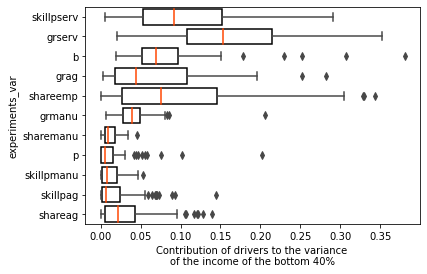

In [16]:
ax = sns.boxplot(data=anova_countries, x='incbott40', y='experiments_var',  orient='h')

ax.set_xlabel('Contribution of drivers to the variance \nof the income of the bottom 40%')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    ax.lines[4+6*i].set_color('orangered')

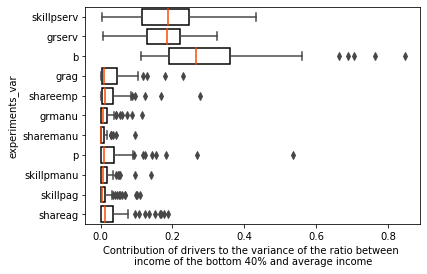

In [17]:
ax = sns.boxplot(data=anova_countries, x='shprosp', y='experiments_var',  orient='h')

ax.set_xlabel('Contribution of drivers to the variance of the ratio between \nincome of the bottom 40% and average income')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    ax.lines[4+6*i].set_color('orangered')

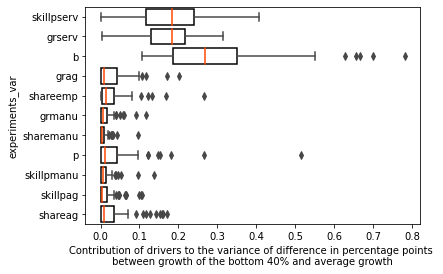

In [18]:
ax = sns.boxplot(data=anova_countries, x='shprosp_pc', y='experiments_var',  orient='h')

ax.set_xlabel('Contribution of drivers to the variance of difference in percentage points \n between growth of the bottom 40% and average growth ')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    ax.lines[4+6*i].set_color('orangered')

In [19]:
ranking_experiments_var = anova_countries.groupby('experiments_var').median()
columns_to_take = int(len(ranking_experiments_var.columns)/2)
ranking_experiments_var = ranking_experiments_var[ranking_experiments_var.columns[columns_to_take:]]

Text(0.5, 14.09375, 'Median ranking of drivers in explaining the \nvariance of different outcome variables\n(Rank 1: most important)')

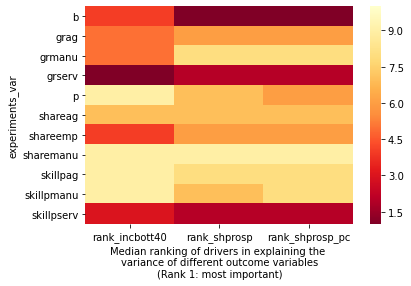

In [20]:
ax = sns.heatmap(ranking_experiments_var, cmap='YlOrRd_r', vmax=len(ranking_experiments_var)-1)
ax.set_xlabel('Median ranking of drivers in explaining the \nvariance of different outcome variables\n(Rank 1: most important)')

surprisingly based on the result above drivers grserv and b are the most important ones, while based on previous analysis (ANOVA - global) driver shareag is the most important. Let's randomly inspect two countries and compare with global results

Text(0.5, 1.0, 'ANOVA for Vietnam')

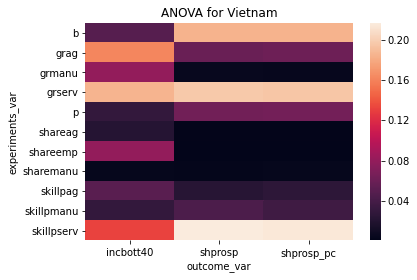

In [22]:
bau_country = bau.loc[bau['country']=='VNM']
anova_country = calculate_anova_all_outcomes(bau_country, outcomes_col, experiments_col)
ax = sns.heatmap(anova_country)
ax.set_title('ANOVA for Vietnam')

Text(0.5, 1.0, 'ANOVA for Indonesia')

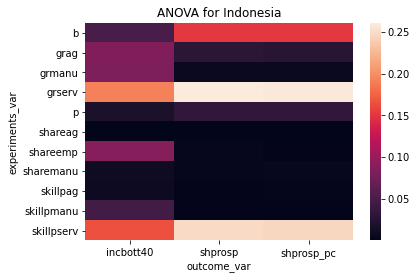

In [23]:
bau_country = bau.loc[bau['country']=='IDN']
anova_country = calculate_anova_all_outcomes(bau_country, outcomes_col, experiments_col)
ax = sns.heatmap(anova_country)
ax.set_title('ANOVA for Indonesia')

Text(0.5, 1.0, 'ANOVA for all countries at once')

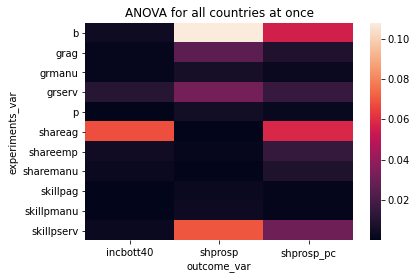

In [24]:
all_anova = calculate_anova_all_outcomes(bau, outcomes_col, experiments_col)
ax = sns.heatmap(all_anova)
ax.set_title('ANOVA for all countries at once')

### Can we cluster the countries based on the most important drivers?

In [25]:
driver_incbott40 = {}
driver_shprosp_pc = {}
ranks_to_include = [1,2,3]
vars_to_include = ['rank_incbott40', 'rank_shprosp_pc']

for c in ini_data['country']:
    anova_country = anova_countries.loc[anova_countries['country']==c]
    important_vars = []
    driver_incbott40[c] = {}
    driver_shprosp_pc[c] = {}
    for rank in ranks_to_include:
        driver_incbott40[c][rank] = anova_country.loc[anova_country['rank_incbott40']==rank]['experiments_var'].iloc[0]
        driver_shprosp_pc[c][rank] = anova_country.loc[anova_country['rank_shprosp_pc']==rank]['experiments_var'].iloc[0] 

In [26]:
for rank in ranks_to_include:
    ini_data['driver_incbott40_'+str(rank)] = ini_data['country'].apply(lambda x: driver_incbott40[x][rank])
    ini_data['driver_shprosp_pc_'+str(rank)] = ini_data['country'].apply(lambda x: driver_shprosp_pc[x][rank])

In [27]:
np.unique(ini_data['driver_incbott40_1'], return_counts=1)

(array(['b', 'grag', 'grserv', 'shareag', 'shareemp', 'skillpserv'],
       dtype=object),
 array([ 4, 16, 49,  3, 15,  4], dtype=int64))

In [28]:
np.unique(ini_data['driver_shprosp_pc_1'], return_counts=1)

(array(['b', 'grag', 'grserv', 'p', 'skillpserv'], dtype=object),
 array([58,  1, 13,  1, 18], dtype=int64))

#### from analysis above it appears that 49 countries have grserv as the most important drivers of incbott40, 58 countries have b as the most important drivers of shprosp_pc

In [29]:
ini_data['driver_incbott40_grserv'] = ini_data['driver_incbott40_1'].apply(lambda x: 1 if x=='grserv' else 0)
ini_data['driver_shprosp_pc_b'] = ini_data['driver_shprosp_pc_1'].apply(lambda x: 1 if x=='b' else 0)

In [30]:
country_characteristics = ['GDP', 'avincome', 'incbott10', 'below10', 'gini', 'tot_pop', 'peopleag', 'peoplenonag', 
                           'avincomeag', 'avincomenonag']

drivers_1,sumvar,table = drivers_from_anova("driver_incbott40_grserv",ini_data,country_characteristics, return_table=True)
drivers_2,sumvar,table = drivers_from_anova("driver_shprosp_pc_b",ini_data,country_characteristics, return_table=True)

In [31]:
from sklearn.datasets import load_iris
from sklearn import tree

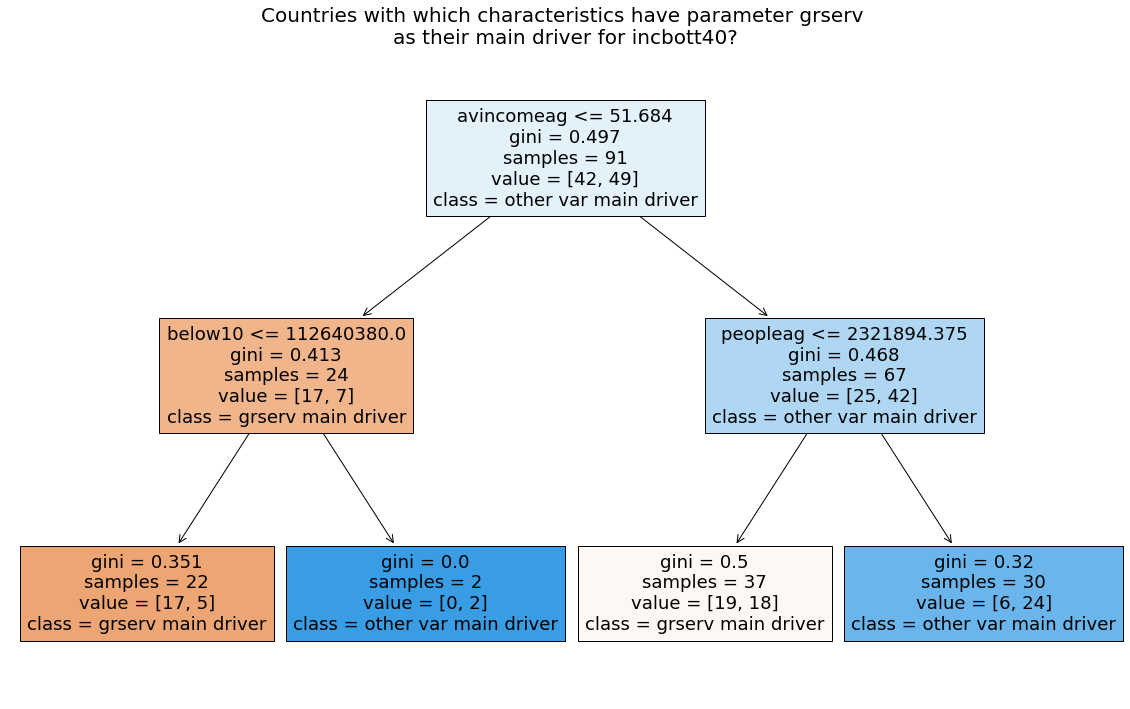

In [32]:
X = ini_data[drivers_1]
y = ini_data['driver_incbott40_grserv']
clf = tree.DecisionTreeClassifier(max_depth=2)

fig, ax = plt.subplots(figsize=(20,12))
tree.plot_tree(clf.fit(X,y), filled=True, feature_names=drivers_1, 
               class_names=['grserv main driver', 'other var main driver'])
plt.title('Countries with which characteristics have parameter grserv \nas their main driver for incbott40?', fontsize=20)
plt.show()

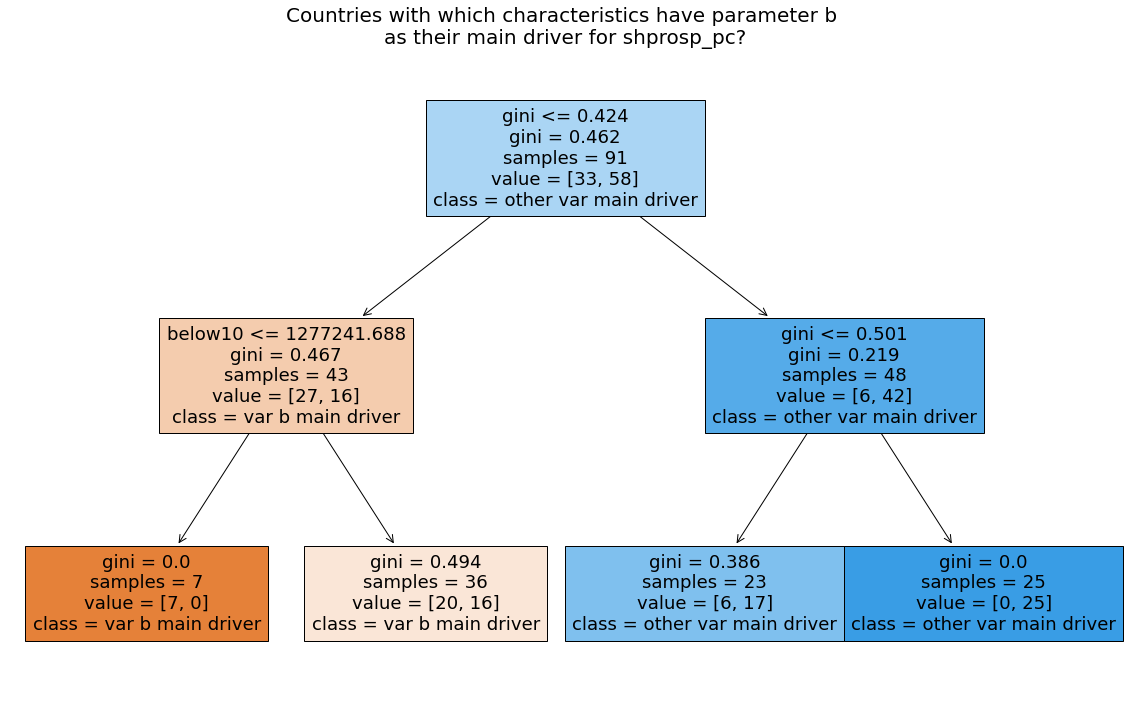

In [33]:
X = ini_data[drivers_2]
y = ini_data['driver_shprosp_pc_b']
clf = tree.DecisionTreeClassifier(max_depth=2)

fig, ax = plt.subplots(figsize=(20,12))
tree.plot_tree(clf.fit(X,y), filled=True, feature_names=drivers_2, 
               class_names=['var b main driver', 'other var main driver'])
plt.title('Countries with which characteristics have parameter b \nas their main driver for shprosp_pc?', fontsize=20)
plt.show()